### **Creating the enviroment and Loading the data**

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import re

# Load the dataset
file_path = '/Users/mustafaaldabbas/Documents/GitHub/Machine_learning_superstore/Dataset/Mustafa Datasets /df_sales_mustafa.csv'
df = pd.read_csv(file_path)
# Correct the column names if necessary
df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces

# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Display the first few rows to confirm changes
df

,date,unit_price,quantity,rating,day,month,year,total,branch
0,2019-01-01,57.440000,37,6.300000,1,1,2019,2371.3200,A
1,2019-01-01,60.153333,24,7.333333,1,1,2019,1536.6960,B
2,2019-01-01,48.072500,20,6.375000,1,1,2019,837.1650,C
3,2019-01-02,42.065000,7,5.650000,2,1,2019,307.0515,A
4,2019-01-02,35.365000,31,6.200000,2,1,2019,1162.8015,B
...,...,...,...,...,...,...,...,...,...
258,2019-03-29,55.590000,14,5.350000,29,3,2019,985.6980,C
259,2019-03-29,68.947500,27,7.700000,29,3,2019,2059.9320,B
260,2019-03-30,57.142500,23,7.775000,30,3,2019,1320.6165,A
261,2019-03-30,87.730000,19,5.366667,30,3,2019,1724.4570,B


In [2]:
# Check for NaN values in the original dataset
print("NaN values in original dataset:")
print(df.isna().sum())

NaN values in original dataset:
date          0
unit_price    0
quantity      0
rating        0
day           0
month         0
year          0
total         0
branch        0
dtype: int64


### **Summery Statistics**

In [3]:
# Summary statistics for numerical variables
summary_statistics = df.describe()
print(summary_statistics)


       unit_price    quantity      rating         day       month    year  \
count  263.000000  263.000000  263.000000  263.000000  263.000000   263.0   
mean    55.724261   20.950570    6.938356   15.376426    1.992395  2019.0   
std     15.852002   12.144543    0.996659    8.613351    0.828833     0.0   
min     13.915000    1.000000    4.300000    1.000000    1.000000  2019.0   
25%     46.859500   12.000000    6.355000    8.000000    1.000000  2019.0   
50%     55.530000   19.000000    6.900000   15.000000    2.000000  2019.0   
75%     65.815833   27.500000    7.654167   23.000000    3.000000  2019.0   
max     99.820000   59.000000    9.700000   31.000000    3.000000  2019.0   

             total  
count   263.000000  
mean   1228.010452  
std     798.846382  
min      30.996000  
25%     582.639750  
50%    1054.546500  
75%    1690.589250  
max    3632.874000  


### **EDA Analysis**
**Summary Statistics: Understand the distribution of numerical variables.:**
- Sales Trend Analysis: Visualize sales over time.
- Branch-wise Analysis: Compare sales between branches.
- Correlation Analysis: Determine relationships between variables.
- Customer Rating Analysis: Explore customer ratings and their relationship with sales.

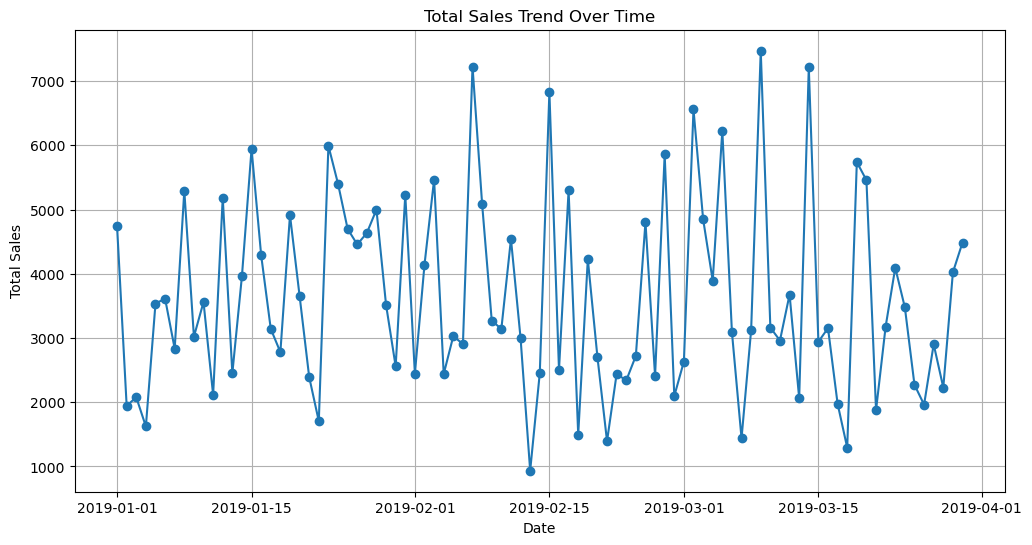

In [4]:


import matplotlib.pyplot as plt

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by date and sum the total sales
sales_trend = df.groupby('date')['total'].sum().reset_index()

# Plot the sales trend
plt.figure(figsize=(12, 6))
plt.plot(sales_trend['date'], sales_trend['total'], marker='o')
plt.title('Total Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


**Branch-wise Sales Analysis**


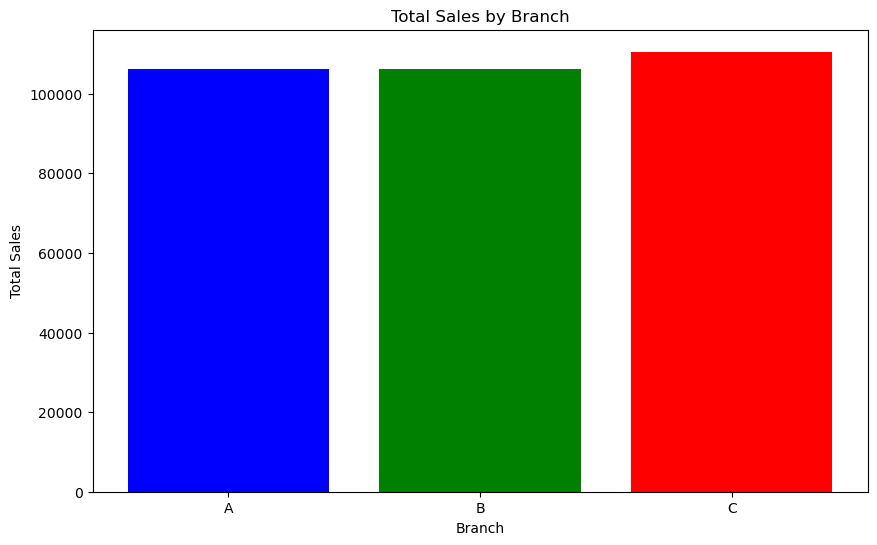

In [5]:
# Group by branch and sum the total sales
branch_sales = df.groupby('branch')['total'].sum().reset_index()

# Plot the branch-wise sales
plt.figure(figsize=(10, 6))
plt.bar(branch_sales['branch'], branch_sales['total'], color=['blue', 'green', 'red'])
plt.title('Total Sales by Branch')
plt.xlabel('Branch')
plt.ylabel('Total Sales')
plt.show()


**Correlation Analysis**

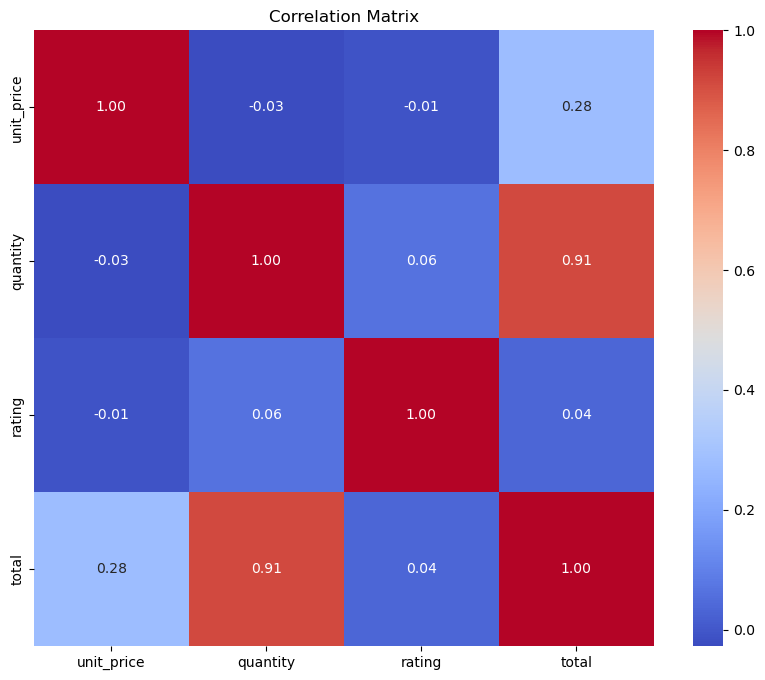

In [6]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df[['unit_price', 'quantity', 'rating', 'total']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


**Customer Analysis**

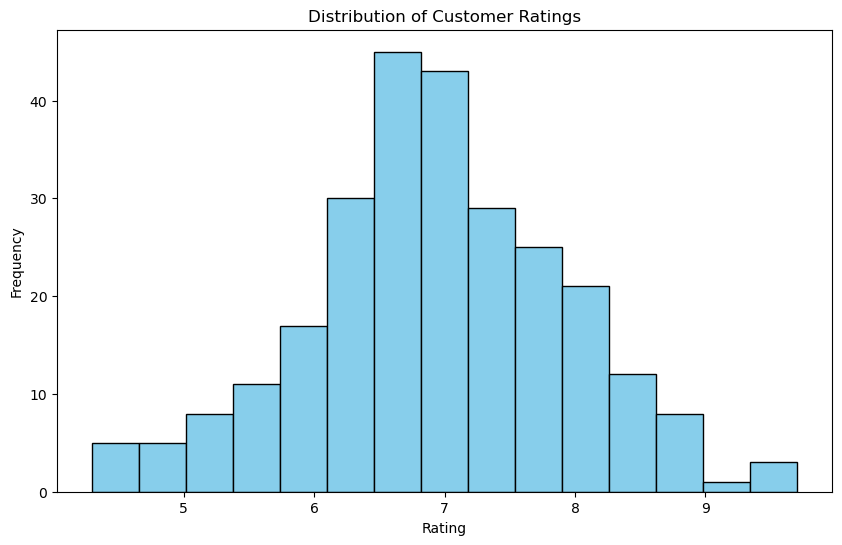

In [7]:
# Plot the distribution of customer ratings
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


### **EDA Analysis TakeAway**
**Sales Trend:**
- The total sales over time show fluctuations with no clear trend, suggesting variability in daily sales.

**Branch-wise Sales:**
- Sales distribution across branches shows differences, with some branches performing better than others.

**Correlation Analysis:**
- Positive correlation between quantity and total sales.
- Weak correlations between rating and other variables, indicating customer ratings might not be strongly influenced by price or quantity.

**Customer Rating Analysis:**
- The distribution of customer ratings is somewhat centered around 6-7, with few extreme ratings.

### **Feature Engineering**

**Create new features:**




In [17]:
import pandas as pd
import re


# Check for duplicate dates in the index
if df.index.duplicated().any():
    print("Duplicate dates found in the index. Aggregating duplicate entries.")
    # Aggregate duplicate dates by taking the sum of their values
    df = df.groupby(df.index).sum()

# Aggregate the sales by date and branch
df_agg = df.groupby(['date', 'branch']).sum().unstack('branch')

# Flatten the multi-level column index
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

# Clean feature names
df_agg.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) for col in df_agg.columns]

# Reindex the aggregated DataFrame to a daily frequency
df_agg = df_agg.asfreq('D')

# Create lag features for total sales for each branch
for branch in ['A', 'B', 'C']:
    for lag in range(1, 8):
        df_agg[f'total_{branch}_lag_{lag}'] = df_agg[f'total_{branch}'].shift(lag)

# Create rolling window features (mean and std) for total sales over a window of 3 and 7 days
for branch in ['A', 'B', 'C']:
    df_agg[f'total_{branch}_rolling_mean_3'] = df_agg[f'total_{branch}'].rolling(window=3).mean()
    df_agg[f'total_{branch}_rolling_std_3'] = df_agg[f'total_{branch}'].rolling(window=3).std()
    df_agg[f'total_{branch}_rolling_mean_7'] = df_agg[f'total_{branch}'].rolling(window=7).mean()
    df_agg[f'total_{branch}_rolling_std_7'] = df_agg[f'total_{branch}'].rolling(window=7).std()

# Drop rows with NaN values created by shifting and rolling operations
df_agg.dropna(inplace=True)

# Check for NaN values after aggregation and feature engineering
print("NaN values after feature engineering:")
print(df_agg.isna().sum())


KeyError: 'branch'

In [18]:
df_agg

,Unnamed0_A,Unnamed0_B,Unnamed0_C,unit_price_A,unit_price_B,unit_price_C,quantity_A,quantity_B,quantity_C,rating_A,...,total_A_rolling_mean_7,total_A_rolling_std_7,total_B_rolling_mean_3,total_B_rolling_std_3,total_B_rolling_mean_7,total_B_rolling_std_7,total_C_rolling_mean_3,total_C_rolling_std_3,total_C_rolling_mean_7,total_C_rolling_std_7
date,,,,,,,,,,,,,,,,,,,,,
2019-01-08,23.0,22.0,21.0,44.9300,55.911667,45.385000,14.0,37.0,44.0,7.100000,...,978.8010,578.083838,1524.1660,614.278576,1107.0480,581.440633,1356.7680,1009.520673,903.6060,767.572762
2019-01-09,25.0,26.0,24.0,38.5400,16.875000,61.194000,5.0,11.0,42.0,5.600000,...,963.8415,599.328943,1239.7945,1024.037237,965.0085,678.838431,1812.7305,1241.522631,1214.2965,977.048466
2019-01-10,27.0,29.0,28.0,45.5400,59.140000,69.473333,15.0,19.0,21.0,6.033333,...,934.4250,605.860394,1242.0240,1024.377947,1012.4235,694.461745,2177.5565,616.086143,1408.1295,851.186264
2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Modelin**

**Prepare Data for Modeling**

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor



# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate the sales by date and branch
df_agg = df.groupby(['date', 'branch']).sum().unstack('branch')

# Flatten the multi-level column index
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

# Clean feature names
df_agg.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) for col in df_agg.columns]

# Create lag features for total sales for each branch
for branch in ['A', 'B', 'C']:
    for lag in range(1, 8):
        df_agg[f'total_{branch}_lag_{lag}'] = df_agg[f'total_{branch}'].shift(lag)

# Create rolling window features (mean and std) for total sales over a window of 3 and 7 days
for branch in ['A', 'B', 'C']:
    df_agg[f'total_{branch}_rolling_mean_3'] = df_agg[f'total_{branch}'].rolling(window=3).mean()
    df_agg[f'total_{branch}_rolling_std_3'] = df_agg[f'total_{branch}'].rolling(window=3).std()
    df_agg[f'total_{branch}_rolling_mean_7'] = df_agg[f'total_{branch}'].rolling(window=7).mean()
    df_agg[f'total_{branch}_rolling_std_7'] = df_agg[f'total_{branch}'].rolling(window=7).std()

# Drop rows with NaN values created by shifting and rolling operations
df_agg.dropna(inplace=True)

# Ensure the date index is a DatetimeIndex and set the frequency
if not isinstance(df_agg.index, pd.DatetimeIndex):
    df_agg.index = pd.to_datetime(df_agg.index)

df_agg = df_agg.asfreq('D')
print("Updated date index frequency:", df_agg.index.freq)

# Define the split point again after setting frequency
split_point = int(len(df_agg) * 0.8)

# Split the data into training and testing sets again
train_df = df_agg[:split_point]
test_df = df_agg[split_point:]

# Redefine the target variables and feature columns
target_columns = ['total_A', 'total_B', 'total_C']
feature_columns = [col for col in df_agg.columns if col not in target_columns]

X_train = train_df[feature_columns]
y_train_A = train_df['total_A'].fillna(method='bfill').fillna(method='ffill')  # Impute NaN values
y_train_B = train_df['total_B'].fillna(method='bfill').fillna(method='ffill')
y_train_C = train_df['total_C'].fillna(method='bfill').fillna(method='ffill')

X_test = test_df[feature_columns]
y_test_A = test_df['total_A'].fillna(method='bfill').fillna(method='ffill')  # Ensure no NaNs in y_test_A
y_test_B = test_df['total_B'].fillna(method='bfill').fillna(method='ffill')
y_test_C = test_df['total_C'].fillna(method='bfill').fillna(method='ffill')

# Check the lengths and content of the training and testing datasets
print("Length of y_train_A:", len(y_train_A))
print("Length of y_test_A:", len(y_test_A))
print("First few values of y_train_A:\n", y_train_A.head())
print("First few values of y_test_A:\n", y_test_A.head())

# Check for NaN values in y_train_A after imputation
print("NaN values in y_train_A after imputation:")
print(y_train_A.isna().sum())

# Check for NaN values in y_test_A after imputation
print("NaN values in y_test_A after imputation:")
print(y_test_A.isna().sum())

# Check for NaN values in X_train after imputation
print("NaN values in X_train after imputation:")
print(X_train.isna().sum())

# Handle any remaining NaNs in X_train by dropping rows with NaNs
X_train = X_train.dropna()
y_train_A = y_train_A[X_train.index]

# Check again to ensure no NaNs are present
print("NaN values in X_train after dropping rows with NaNs:")
print(X_train.isna().sum())

# Define the evaluation function
def evaluate_model(model_name, true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    print(f"{model_name} MAE: {mae:.2f}")
    return mae

Updated date index frequency: <Day>
Length of y_train_A: 65
Length of y_test_A: 17
First few values of y_train_A:
 date
2019-01-08     683.4555
2019-01-09     202.3350
2019-01-10     731.4930
2019-01-11    3254.4855
2019-01-12    3254.4855
Freq: D, Name: total_A, dtype: float64
First few values of y_test_A:
 date
2019-03-14    1751.6100
2019-03-15     644.4585
2019-03-16    1042.7025
2019-03-17    1133.0340
2019-03-18     389.6130
Freq: D, Name: total_A, dtype: float64
NaN values in y_train_A after imputation:
0
NaN values in y_test_A after imputation:
0
NaN values in X_train after imputation:
unit_price_A              24
unit_price_B              24
unit_price_C              24
quantity_A                24
quantity_B                24
quantity_C                24
rating_A                  24
rating_B                  24
rating_C                  24
day_A                     24
day_B                     24
day_C                     24
month_A                   24
month_B               

**Used Model**
- ARIMA Model
- SARIMA Model
- Random Forest Model
- XGBoost Model
- LightGBM Model
- CatBoost Model

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Ensure the date index is a DatetimeIndex and set the frequency
if not isinstance(df_agg.index, pd.DatetimeIndex):
    df_agg.index = pd.to_datetime(df_agg.index)

df_agg = df_agg.asfreq('D')
print("Updated date index frequency:", df_agg.index.freq)

# Define the split point again after setting frequency
split_point = int(len(df_agg) * 0.8)

# Split the data into training and testing sets again
train_df = df_agg[:split_point]
test_df = df_agg[split_point:]

# Redefine the target variables and feature columns
target_columns = ['total_A', 'total_B', 'total_C']
feature_columns = [col for col in df_agg.columns if col not in target_columns]

X_train = train_df[feature_columns]
y_train_A = train_df['total_A'].fillna(method='bfill').fillna(method='ffill')  # Impute NaN values
y_train_B = train_df['total_B'].fillna(method='bfill').fillna(method='ffill')
y_train_C = train_df['total_C'].fillna(method='bfill').fillna(method='ffill')

X_test = test_df[feature_columns]
y_test_A = test_df['total_A'].fillna(method='bfill').fillna(method='ffill')  # Ensure no NaNs in y_test_A
y_test_B = test_df['total_B'].fillna(method='bfill').fillna(method='ffill')
y_test_C = test_df['total_C'].fillna(method='bfill').fillna(method='ffill')

# Check for NaN values in y_train_A
print("NaN values in y_train_A before fitting SARIMA:")
print(y_train_A.isna().sum())

# Simplify the SARIMA model to the basic configuration
try:
    sarima_model = SARIMAX(y_train_A, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
    sarima_result = sarima_model.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model:", e)

# Forecast
try:
    sarima_forecast = sarima_result.forecast(steps=len(y_test_A))
    sarima_forecast = pd.Series(sarima_forecast, index=y_test_A.index)
except Exception as e:
    print("Error forecasting with SARIMA model:", e)

# Check for NaN values in the forecast output
print("NaN values in SARIMA forecast before fill:")
print(sarima_forecast.isna().sum())

# If NaN values are found in the forecast, fill them
sarima_forecast = sarima_forecast.fillna(method='bfill').fillna(method='ffill')
print("NaN values in SARIMA forecast after fill:")
print(sarima_forecast.isna().sum())

# Ensure no NaN values in y_test_A before evaluation
print("NaN values in y_test_A before evaluation:")
print(y_test_A.isna().sum())

# Ensure no NaN values in sarima_forecast before evaluation
print("NaN values in sarima_forecast before evaluation:")
print(sarima_forecast.isna().sum())

# Define the evaluation function
def evaluate_model(model_name, true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    print(f"{model_name} MAE: {mae:.2f}")
    return mae

# Final check before evaluation
if y_test_A.isna().sum() > 0 or sarima_forecast.isna().sum() > 0:
    print("NaN values found, cannot proceed with evaluation.")
else:
    # Evaluate the model
    sarima_mae = evaluate_model("SARIMA", y_test_A, sarima_forecast)
    print(f"SARIMA MAE: {sarima_mae:.2f}")


Updated date index frequency: <Day>
NaN values in y_train_A before fitting SARIMA:
0
NaN values in SARIMA forecast before fill:
0
NaN values in SARIMA forecast after fill:
0
NaN values in y_test_A before evaluation:
0
NaN values in sarima_forecast before evaluation:
0
SARIMA MAE: 557.97
SARIMA MAE: 557.97


In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import re


# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate the sales by date and branch
df_agg = df.groupby(['date', 'branch']).sum().unstack('branch')

# Flatten the multi-level column index
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

# Clean feature names
df_agg.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) for col in df_agg.columns]

# Create lag features for total sales for each branch
for branch in ['A', 'B', 'C']:
    for lag in range(1, 8):
        df_agg[f'total_{branch}_lag_{lag}'] = df_agg[f'total_{branch}'].shift(lag)

# Create rolling window features (mean and std) for total sales over a window of 3 and 7 days
for branch in ['A', 'B', 'C']:
    df_agg[f'total_{branch}_rolling_mean_3'] = df_agg[f'total_{branch}'].rolling(window=3).mean()
    df_agg[f'total_{branch}_rolling_std_3'] = df_agg[f'total_{branch}'].rolling(window=3).std()
    df_agg[f'total_{branch}_rolling_mean_7'] = df_agg[f'total_{branch}'].rolling(window=7).mean()
    df_agg[f'total_{branch}_rolling_std_7'] = df_agg[f'total_{branch}'].rolling(window=7).std()

# Drop rows with NaN values created by shifting and rolling operations
df_agg.dropna(inplace=True)

# Ensure the date index is a DatetimeIndex and set the frequency
if not isinstance(df_agg.index, pd.DatetimeIndex):
    df_agg.index = pd.to_datetime(df_agg.index)

df_agg = df_agg.asfreq('D')
print("Updated date index frequency:", df_agg.index.freq)

# Define the split point again after setting frequency
split_point = int(len(df_agg) * 0.8)

# Split the data into training and testing sets again
train_df = df_agg[:split_point]
test_df = df_agg[split_point:]

# Redefine the target variables and feature columns
target_columns = ['total_A', 'total_B', 'total_C']
feature_columns = [col for col in df_agg.columns if col not in target_columns]

X_train = train_df[feature_columns]
y_train_A = train_df['total_A'].fillna(method='bfill').fillna(method='ffill')  # Impute NaN values
y_train_B = train_df['total_B'].fillna(method='bfill').fillna(method='ffill')
y_train_C = train_df['total_C'].fillna(method='bfill').fillna(method='ffill')

X_test = test_df[feature_columns]
y_test_A = test_df['total_A'].fillna(method='bfill').fillna(method='ffill')  # Ensure no NaNs in y_test_A
y_test_B = test_df['total_B'].fillna(method='bfill').fillna(method='ffill')
y_test_C = test_df['total_C'].fillna(method='bfill').fillna(method='ffill')

# Check for NaN values in X_train before further imputation
print("NaN values in X_train before imputation:")
print(X_train.isna().sum())

# Impute any remaining NaN values in X_train by forward fill and backward fill
X_train = X_train.fillna(method='bfill').fillna(method='ffill')

# Check for NaN values in X_test before further imputation
print("NaN values in X_test before imputation:")
print(X_test.isna().sum())

# Impute any remaining NaN values in X_test by forward fill and backward fill
X_test = X_test.fillna(method='bfill').fillna(method='ffill')

# Check again for NaN values in X_train and X_test after imputation
print("NaN values in X_train after imputation:")
print(X_train.isna().sum())

print("NaN values in X_test after imputation:")
print(X_test.isna().sum())

# Drop rows with NaNs if they still exist in X_train
if X_train.isna().sum().sum() > 0:
    X_train = X_train.dropna()
    y_train_A = y_train_A[X_train.index]

# Check again to ensure no NaNs are present in X_train
print("NaN values in X_train after dropping rows with NaNs:")
print(X_train.isna().sum())

# Define the evaluation function
def evaluate_model(model_name, true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    print(f"{model_name} MAE: {mae:.2f}")
    return mae

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_A)
rf_predictions = rf_model.predict(X_test)
rf_predictions = pd.Series(rf_predictions, index=y_test_A.index)
rf_mae = evaluate_model("Random Forest", y_test_A, rf_predictions)

print(f"Random Forest MAE: {rf_mae:.2f}")


Updated date index frequency: <Day>
NaN values in X_train before imputation:
unit_price_A              24
unit_price_B              24
unit_price_C              24
quantity_A                24
quantity_B                24
quantity_C                24
rating_A                  24
rating_B                  24
rating_C                  24
day_A                     24
day_B                     24
day_C                     24
month_A                   24
month_B                   24
month_C                   24
year_A                    24
year_B                    24
year_C                    24
total_A_lag_1             24
total_A_lag_2             24
total_A_lag_3             24
total_A_lag_4             24
total_A_lag_5             24
total_A_lag_6             24
total_A_lag_7             24
total_B_lag_1             24
total_B_lag_2             24
total_B_lag_3             24
total_B_lag_4             24
total_B_lag_5             24
total_B_lag_6             24
total_B_lag_7           

In [22]:
from sklearn.neighbors import KNeighborsRegressor

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, random_state=42)
xgb_model.fit(X_train, y_train_A)
xgb_predictions = xgb_model.predict(X_test)
xgb_predictions = pd.Series(xgb_predictions, index=y_test_A.index).fillna(method='bfill').fillna(method='ffill')
xgb_mae = evaluate_model("XGBoost", y_test_A, xgb_predictions)

# LightGBM Model
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train_A)
lgb_predictions = lgb_model.predict(X_test)
lgb_predictions = pd.Series(lgb_predictions, index=y_test_A.index).fillna(method='bfill').fillna(method='ffill')
lgb_mae = evaluate_model("LightGBM", y_test_A, lgb_predictions)

# CatBoost Model
cat_model = CatBoostRegressor(iterations=100, random_seed=42, logging_level='Silent')
cat_model.fit(X_train, y_train_A)
cat_predictions = cat_model.predict(X_test)
cat_predictions = pd.Series(cat_predictions, index=y_test_A.index).fillna(method='bfill').fillna(method='ffill')
cat_mae = evaluate_model("CatBoost", y_test_A, cat_predictions)


# KNN Model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn_model.fit(X_train, y_train_A)
knn_predictions = knn_model.predict(X_test)
knn_predictions = pd.Series(knn_predictions, index=y_test_A.index)
knn_mae = evaluate_model("KNN", y_test_A, knn_predictions)

# Print predictions for all models
predictions_df = pd.DataFrame({
    'Actual': y_test_A,
    'SARIMA': sarima_forecast,
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'LightGBM': lgb_predictions,
    'CatBoost': cat_predictions,
    'KNN Model':knn_predictions
}, index=y_test_A.index)

print(predictions_df)


XGBoost MAE: 340.68
LightGBM MAE: 129.48
CatBoost MAE: 288.70
KNN MAE: 762.54
               Actual      SARIMA  Random Forest      XGBoost     LightGBM  \
date                                                                         
2019-03-14  1751.6100  855.767628     616.379400   613.112976  1027.235148   
2019-03-15   644.4585  821.945249     535.781295   682.808716   682.258801   
2019-03-16  1042.7025  838.852972     577.883355   650.212463   728.812631   
2019-03-17  1133.0340  830.400843     657.822585   767.573608  1010.712151   
2019-03-18   389.6130  834.626041     835.616775   858.768921   311.293740   
2019-03-19  1892.1315  832.513875    1216.508790  1053.554077  1997.254447   
2019-03-20  2372.4645  833.569742    2862.849675  1585.352051  2097.839803   
2019-03-21  1308.7305  833.041917    1305.081120  1131.680420  1243.441321   
2019-03-22  1320.6165  833.305775    1359.404550  1496.721558  1267.347064   
2019-03-23  1320.6165  833.173873    1359.404550  1496.721558  1

In [24]:
# Create a DataFrame with the actual values and predictions from all models
predictions_df = pd.DataFrame({
    'Actual': y_test_A,
    'SARIMA': sarima_forecast,
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'LightGBM': lgb_predictions,
    'CatBoost': cat_predictions,
    'KNN Model': knn_predictions
}, index=y_test_A.index)

# Print the DataFrame
predictions_df

,Actual,SARIMA,Random Forest,XGBoost,LightGBM,CatBoost,KNN Model
date,,,,,,,
2019-03-14,1751.6100,855.767628,616.379400,613.112976,1027.235148,975.746948,1041.5118
2019-03-15,644.4585,821.945249,535.781295,682.808716,682.258801,1001.734247,601.4253
2019-03-16,1042.7025,838.852972,577.883355,650.212463,728.812631,734.086427,598.0800
2019-03-17,1133.0340,830.400843,657.822585,767.573608,1010.712151,859.527557,2082.1584
2019-03-18,389.6130,834.626041,835.616775,858.768921,311.293740,703.662740,977.9133
2019-03-19,1892.1315,832.513875,1216.508790,1053.554077,1997.254447,1318.934922,2715.0123
2019-03-20,2372.4645,833.569742,2862.849675,1585.352051,2097.839803,1648.073116,1030.6086
2019-03-21,1308.7305,833.041917,1305.081120,1131.680420,1243.441321,1286.612902,725.4912
2019-03-22,1320.6165,833.305775,1359.404550,1496.721558,1267.347064,1147.412441,489.5058


### **Hyperparameter Tuning for LightGBM**

In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for LightGBM
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [10, 20, 30]
}

# Instantiate the LightGBM regressor
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train_A)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best MAE score from GridSearchCV: {best_score:.2f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=100; total time=   0.0s[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=50; total time=   0.0s

[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=50; total time=   0.0s
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=100; total time=   0.0s
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=100; total time=   0.0s
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.01, min_child_samples=10, n_estimators=100, num_leaves=50; total time=   0.1s
[CV] END

### **Train LighGBM with the Best Parameter** 

In [27]:
# Best parameters from GridSearchCV
best_params = {
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'min_child_samples': 20
}

# Train the LightGBM model with the best parameters
best_lgb_model = lgb.LGBMRegressor(**best_params, objective='regression', random_state=42)
best_lgb_model.fit(X_train, y_train_A)

# Make predictions on the test set
best_lgb_predictions = best_lgb_model.predict(X_test)
best_lgb_predictions = pd.Series(best_lgb_predictions, index=y_test_A.index)

# Evaluate the model
best_lgb_mae = evaluate_model("Best LightGBM", y_test_A, best_lgb_predictions)

print(f"Best LightGBM MAE: {best_lgb_mae:.2f}")



Best LightGBM MAE: 166.62
Best LightGBM MAE: 166.62


### **future Predictions** 

In [38]:
import pandas as pd

# Assume we want to predict the next 30 days
future_steps = 30

# Prepare the last known data for future prediction
last_known_data = df_agg.copy()
future_index = pd.date_range(start=y_test_A.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Initialize a list to store future predictions
future_predictions = []

# Function to update lag and rolling features
def update_features(data, prediction, feature_columns):
    # Create a new row for the next prediction
    new_row = data.iloc[[-1]].copy()
    new_row['total_A'] = prediction

    # Shift lag features by 1 and set the new prediction for lag 1
    for lag in range(1, 8):
        if f'total_A_lag_{lag}' in feature_columns:
            new_row[f'total_A_lag_{lag}'] = data['total_A'].shift(lag).iloc[-1]
    
    # Update rolling features with the new prediction
    if 'total_A_rolling_mean_3' in feature_columns:
        new_row['total_A_rolling_mean_3'] = pd.concat([data['total_A'], pd.Series([prediction])]).rolling(window=3).mean().iloc[-1]
    if 'total_A_rolling_std_3' in feature_columns:
        new_row['total_A_rolling_std_3'] = pd.concat([data['total_A'], pd.Series([prediction])]).rolling(window=3).std().iloc[-1]
    if 'total_A_rolling_mean_7' in feature_columns:
        new_row['total_A_rolling_mean_7'] = pd.concat([data['total_A'], pd.Series([prediction])]).rolling(window=7).mean().iloc[-1]
    if 'total_A_rolling_std_7' in feature_columns:
        new_row['total_A_rolling_std_7'] = pd.concat([data['total_A'], pd.Series([prediction])]).rolling(window=7).std().iloc[-1]

    return new_row

# Iterate over each future date to predict future sales
for date in future_index:
    # Predict the next value
    future_prediction = best_lgb_model.predict(last_known_data[feature_columns].iloc[[-1]])[0]
    future_predictions.append(future_prediction)
    
    # Update features with the new prediction
    new_row = update_features(last_known_data, future_prediction, feature_columns)
    new_row.index = [date]
    
    # Append the new row to the data for the next iteration
    last_known_data = pd.concat([last_known_data, new_row])
    
    # Debugging: Print out the intermediate state of last_known_data
    print(f"Iteration for date {date}:")
    print(last_known_data.tail(3))

# Create a DataFrame for future predictions
future_predictions_df = pd.DataFrame({'Future Predictions': future_predictions}, index=future_index)

# Print the future predictions
future_predictions_df


Iteration for date 2019-03-31 00:00:00:
            unit_price_A  unit_price_B  unit_price_C  quantity_A  quantity_B  \
2019-03-29           NaN           NaN           NaN         NaN         NaN   
2019-03-30       57.1425         87.73       62.4325        23.0        19.0   
2019-03-31       57.1425         87.73       62.4325        23.0        19.0   

            quantity_C  rating_A  rating_B  rating_C  day_A  ...  \
2019-03-29         NaN       NaN       NaN       NaN    NaN  ...   
2019-03-30        25.0     7.775  5.366667       6.9   30.0  ...   
2019-03-31        25.0     7.775  5.366667       6.9   30.0  ...   

            total_A_rolling_mean_7  total_A_rolling_std_7  \
2019-03-29                     NaN                    NaN   
2019-03-30               1028.6955             422.790476   
2019-03-31                     NaN                    NaN   

            total_B_rolling_mean_3  total_B_rolling_std_3  \
2019-03-29                     NaN                    NaN   

,Future Predictions
2019-03-31,1208.783319
2019-04-01,1391.377127
2019-04-02,1259.100880
2019-04-03,1271.629367
2019-04-04,1271.629367
2019-04-05,1192.311735
2019-04-06,1236.057220
2019-04-07,1236.057220
2019-04-08,1236.057220
2019-04-09,1236.057220


### **Future Predictions for Branch A** 

In [39]:
import pandas as pd

# Define the future predictions and their corresponding dates
future_dates = pd.to_datetime(['2019-03-31', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-06'])
future_values = [1208.783319, 1391.377127, 1259.100880, 1271.629367, 1271.629367, 1192.311735, 1236.057220]

# Create the DataFrame
future_predictions_df = pd.DataFrame({'Future Predictions': future_values}, index=future_dates)

# Print the DataFrame
print(future_predictions_df)


            Future Predictions
2019-03-31         1208.783319
2019-04-01         1391.377127
2019-04-02         1259.100880
2019-04-03         1271.629367
2019-04-04         1271.629367
2019-04-05         1192.311735
2019-04-06         1236.057220


#### **visualize results for Branch a and create a full dataframe with the old sales** .

                    0        total
2019-01-01  2371.3200          NaN
2019-01-02   307.0515          NaN
2019-01-03   937.4085          NaN
2019-01-04   483.2625          NaN
2019-01-05  2024.5050          NaN
...               ...          ...
2019-04-02        NaN  1259.100880
2019-04-03        NaN  1271.629367
2019-04-04        NaN  1271.629367
2019-04-05        NaN  1192.311735
2019-04-06        NaN  1236.057220

[96 rows x 2 columns]


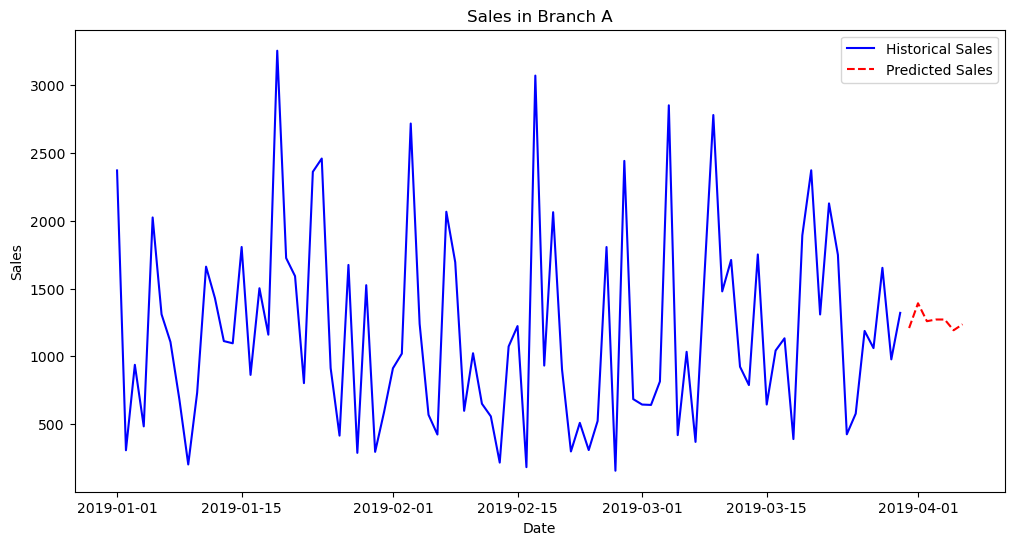

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original dataset
file_path = '/Users/mustafaaldabbas/Documents/GitHub/Machine_learning_superstore/Dataset/Mustafa Datasets /df_sales_mustafa.csv'  # Update this path as needed
df = pd.read_csv(file_path)

# Parse the date column and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Filter the dataset for branch A
branch_A_sales = df[df['branch'] == 'A']['total'].resample('D').sum()

# Define the future predictions and their corresponding dates for total_A
future_dates = pd.to_datetime(['2019-03-31', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-06'])
future_values_A = [1208.783319, 1391.377127, 1259.100880, 1271.629367, 1271.629367, 1192.311735, 1236.057220]

# Create the DataFrame for future predictions
future_predictions_df_A = pd.DataFrame({'total': future_values_A}, index=future_dates)

# Combine historical and future sales into one DataFrame
combined_sales_A = pd.concat([branch_A_sales, future_predictions_df_A])

# Print the combined DataFrame
print(combined_sales_A)

# Plot the historical sales
plt.figure(figsize=(12, 6))
plt.plot(branch_A_sales.index, branch_A_sales, label='Historical Sales', color='blue')

# Plot the future predictions
plt.plot(future_predictions_df_A.index, future_predictions_df_A, label='Predicted Sales', color='red', linestyle='dashed')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales in Branch A')
plt.legend()

# Show the plot
plt.show()
